In [ ]:
%pip install openai python-dotenv numpy faiss-cpu PyPDF2

In [13]:
from dotenv import load_dotenv
load_dotenv()


True

# Why RAG is Needed

Retrieval Augmented Generation (RAG) has emerged as a promising strategy to mitigate hallucinations in Language Models (LLMs). As concerns around LLM hallucinations have intensified, RAG has increasingly come under the spotlight, paving the way for a range of commercial applications. By retrieving evidence from external knowledge bases, RAG enables LLMs to be equipped with up-to-date knowledge and generate responses conditioning on relevant evidence. However, despite its advantages, RAG also suffers from hallucinations, which poses obstacles for practical applications in real-world scenarios

Challenges Addressed by RAG

Duplication Bias: RAG helps address the issue of duplication bias in LLMs, where the over-prioritization of duplicated data leads to hallucinations that deviate from the desired content

Social Biases: RAG can mitigate biases related to gender and nationality, which can inadvertently propagate into the generated content 

Knowledge Boundary: RAG helps overcome the limitations of LLMs in specialized domains and the absence of up-to-date factual knowledge 

Inferior Data Utilization: RAG aims to improve the utilization of factual knowledge and reduce knowledge-induced hallucinations.

# How RAG works

## 1: Word Embeddings

### Definition and Purpose of Embeddings:

Embeddings are numerical representations of text (words, phrases, sentences, or documents) that capture the semantic meanings in a high-dimensional space.

The main purpose of embeddings is to convert text into a form that can be processed by machine learning algorithms, enabling them to understand and process natural language data.

### Traditional Embedding Techniques:

Word2Vec, GloVe, and BERT. Each uses different methods (like neural networks) to analyze text and produce embeddings.
These models are trained on large datasets to understand context and nuances in language.

### OpenAI

OpenAI offers several pre-trained models that can be used to generate embeddings for text. These models are trained on large datasets to understand context and nuances in language.

They produce the following vector sizes:

`text-embedding-ada-002`: 1536

`text-embedding-3-small`: 1536

`text-embedding-3-large`: 3072

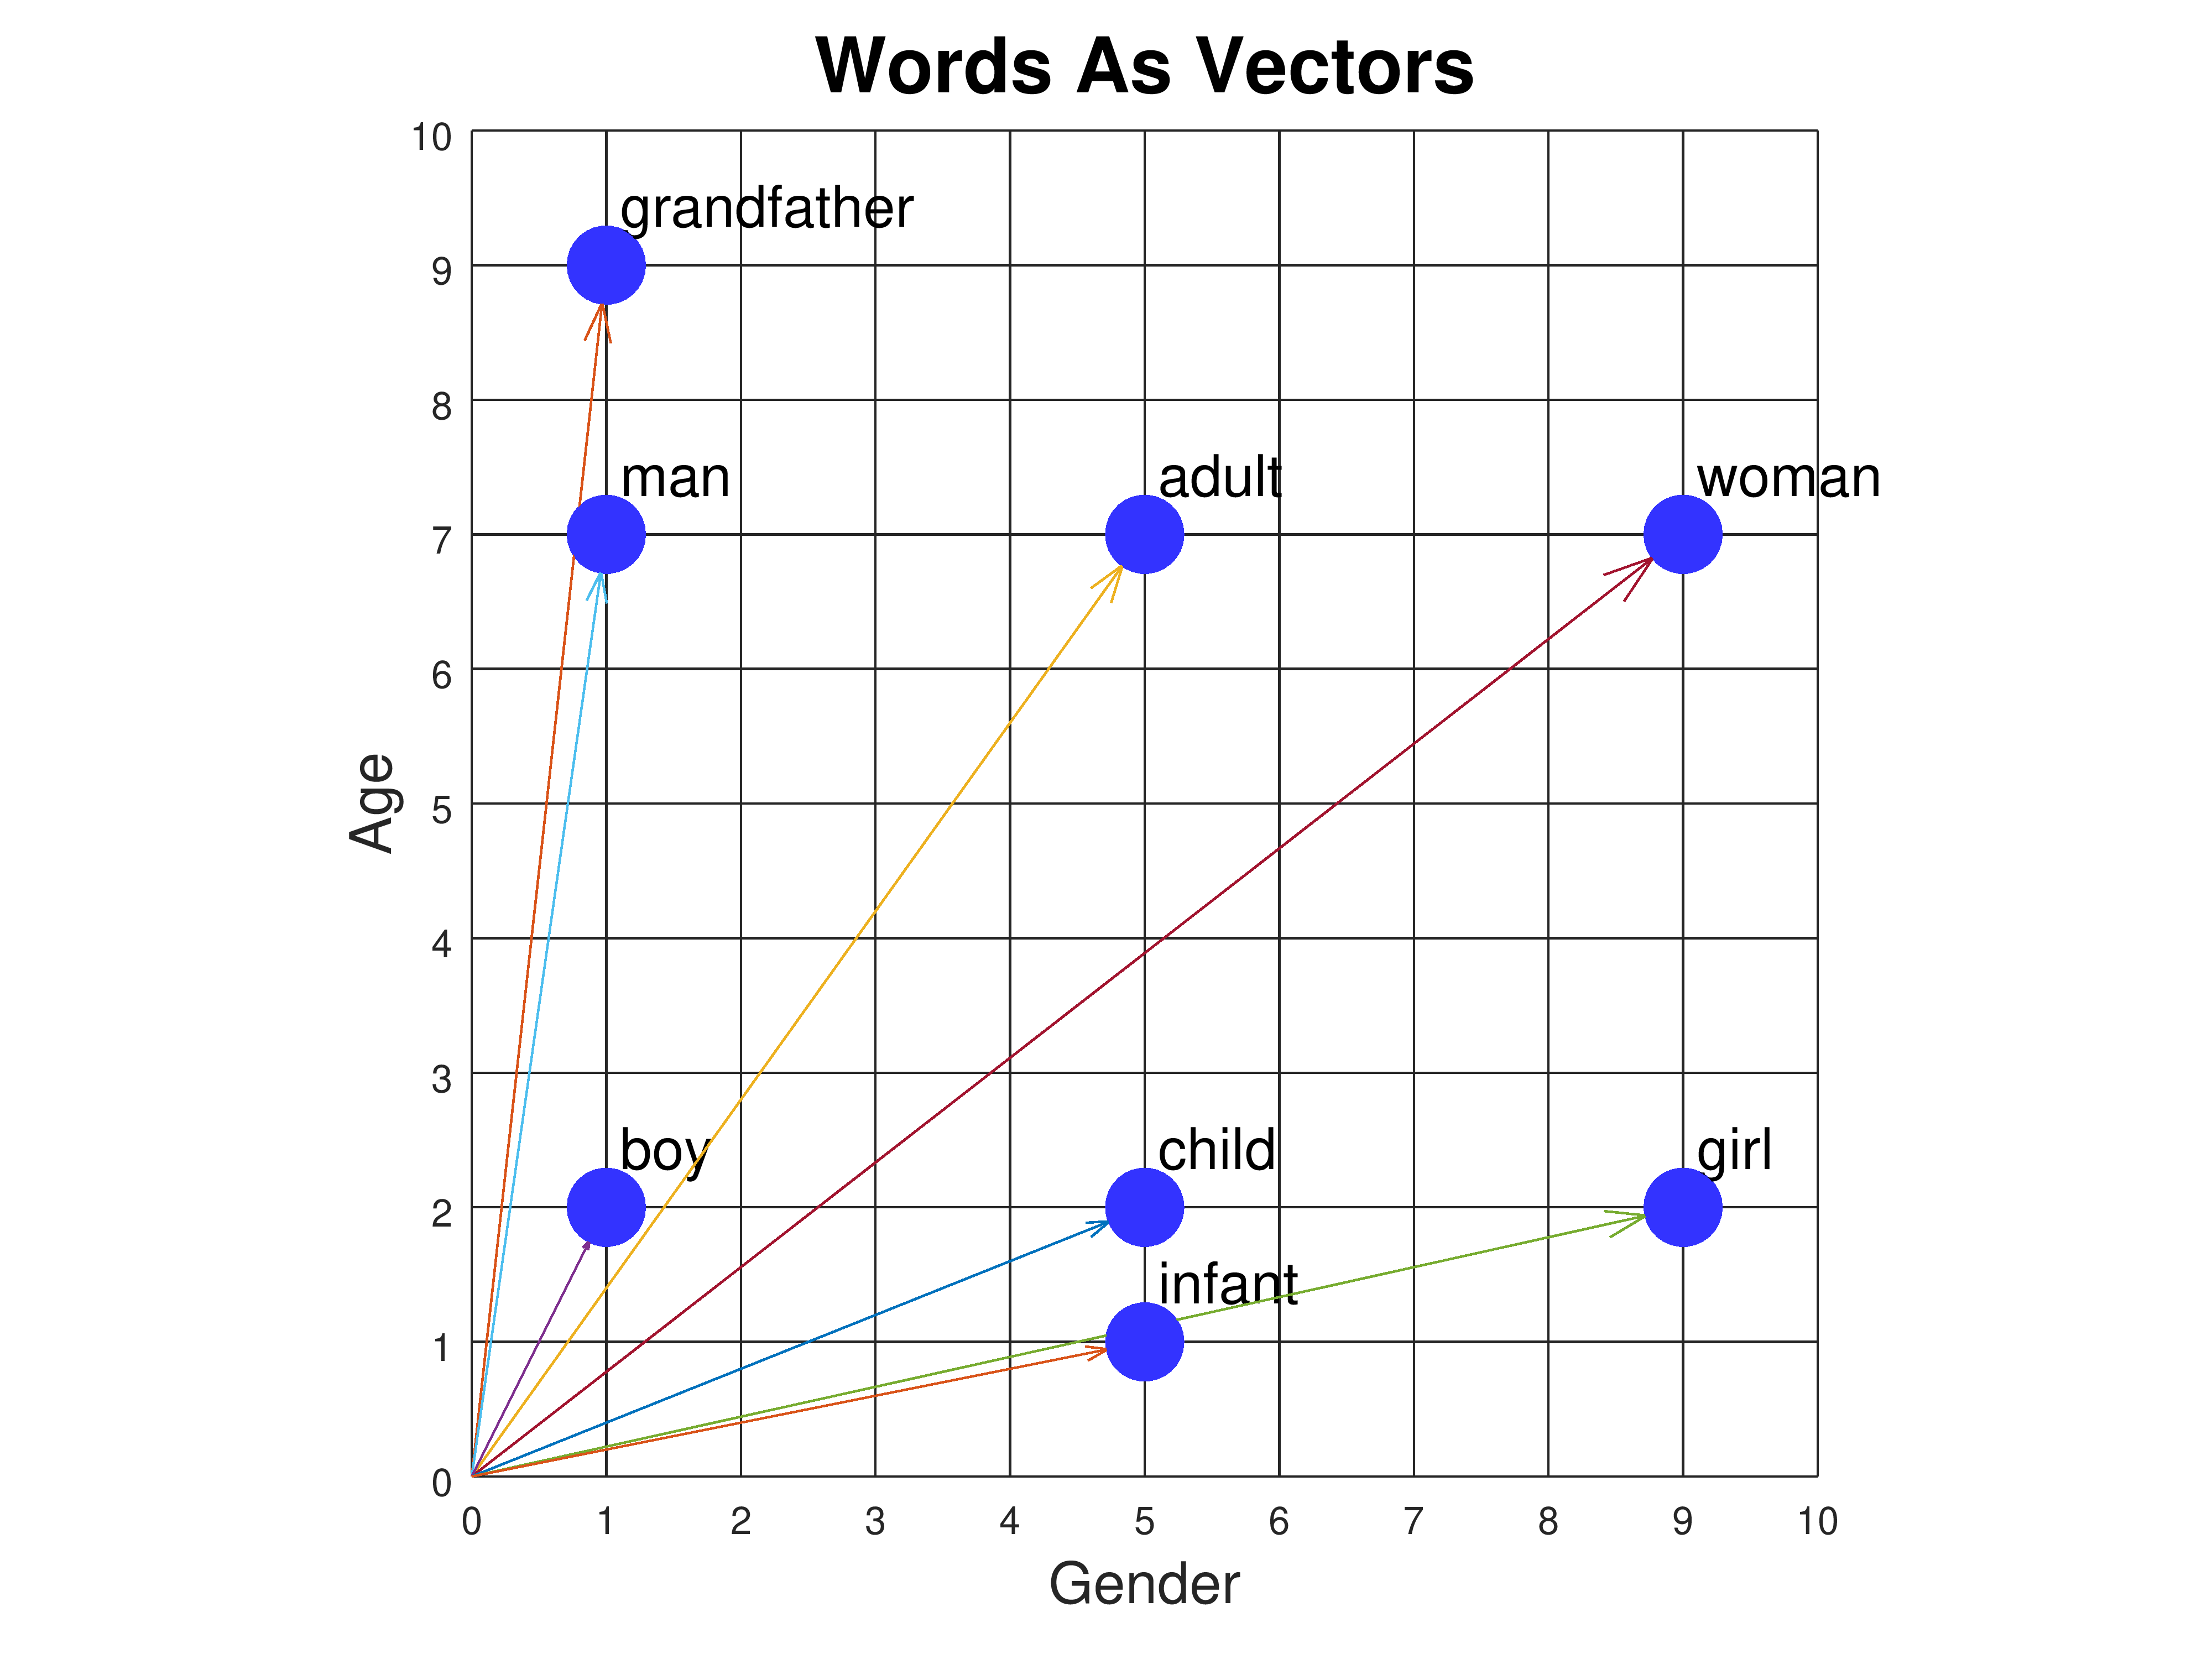

Generally, larger embeddings will produce more accurate representations of text, but will also require more memory and computational resources to generate, search, and store.


In [34]:
from typing import List
from openai import OpenAI

def get_embeddings(text: str) -> List[float]:
    client = OpenAI() # remember to have your OPENAI_API_KEY in the .env file

    response = client.embeddings.create(
        input=text,
        model="text-embedding-3-small"
    )

    return response.data[0].embedding

def get_completion(messages: List[dict]) -> str:
    client = OpenAI() # remember to have your OPENAI_API_KEY in the .env file

    response = client.chat.completions.create(
        model="gpt-3.5-turbo-0125",
        messages=messages
    )

    return response.choices[0].message.content



## 2: Text Chunking

### Why chunk text

Often times, a document may be many pages long, but only a few sentences are relevant to the question. For example, if you are looking for PTO policy, but the document contains all other policies as well, it is inefficient to use the whole document to generate the answer (it is also possibly too long to fit into a prompt)

Text is chunked into smaller pieces to make it easier to search and retrieve relevant information.

### Chunking techniques

There are a few different ways to chunk text, each with its own pros and cons.

#### Fixed length chunking

This is the simplest method of chunking text. It involves splitting the text into chunks of a fixed length. For this chunking method, it is common to include some overlap in the chunks to ensure that no information is lost. There is no strict guideline for chunk size, but common sizes are 256 and 512 words, with about 10% overlap. These tend to work well for GPT models.



In [2]:
sample_text = """

Weather in Vietnam is characterized by its tropical monsoon climate, which leads to significant seasonal variations across the country. The northern region, including Hanoi, experiences a humid subtropical climate with four distinct seasons: a warm spring, a hot and humid summer with heavy rains, a pleasant and cool autumn, and a chilly winter. Summers in the north, typically from May to October, can see significant rainfall due to the southwest monsoon, making this period ideal for the lush growth of crops and vegetation.

Moving southward, the central region, including cities like Hue and Da Nang, has a more tropical savanna climate. This area experiences a longer dry season, with high temperatures and little rainfall from January to August, followed by a wet season from September to December, when the northeast monsoon brings heavy downpours and potential flooding.

The southern part, with Ho Chi Minh City as its major urban center, exhibits a tropical wet and dry climate. It has only two seasons: a dry season from November to April, characterized by high temperatures and minimal rainfall, and a wet season from May to October, marked by frequent but short-lived downpours that can cause localized flooding.

Vietnam's diverse climate significantly impacts agriculture, tourism, and daily life. The wet seasons are critical for rice cultivation, especially in the Mekong Delta in the south and the Red River Delta in the north. However, they also pose challenges like flooding and typhoons. The dry seasons, while more comfortable for travel and outdoor activities, can sometimes bring droughts, affecting water supply and agriculture.

Understanding Vietnam's weather patterns is essential for travelers and residents alike, as they influence everything from clothing choices to the best times for agricultural activities and tourism.
"""

In [3]:
from typing import List


def chunk_text_by_size(text: str, chunk_size: int, overlap: int) -> List[str]:
    chunks = []
    words = text.split()
    for i in range(0, len(words), chunk_size - overlap):
        chunk = " ".join(words[i:i+chunk_size])
        chunks.append(chunk)
    return chunks



In [ ]:
chunk_size = 40
overlap = 5

chunked_text = chunk_text_by_size(sample_text, chunk_size, overlap)
print(chunked_text[0])
print(chunked_text[1])

### Logical chunking. 

One downside with using fixed length chunking is that it may split sentences in the middle, which can lead to incomplete information. This is partially addressed with overlap, but that causes redundancy.

Another method of chunking text is by using sentences. It can be assummed that 1 (or 2 or n) sentences (or even paragraphs, split by \n) represent one logical idea.



In [6]:
def chunk_text_by_sentences(text: str) -> List[str]:
    chunks = text.split(".")
    return chunks


In [ ]:
chunked_text = chunk_text_by_sentences(sample_text)
print(chunked_text[0])
print(chunked_text[1])

### Semantic Chunking

Semantic chunking is a more advanced strategy but can typically lead to improvements in your RAG pipeline if the other 2 methods are insufficient.

It involves first chunking the text in a traditional way (usually by individual sentences), then creating embeddings of each sentence and using semantic search or clustering to group similar sentences together.

This produces chunks of varied lengths but with each chunk containing a logical idea.

## As an exercise, try to implement a semantic chunker from scratch. Don't use prebuilt libraries


The next step is to create embeddings of our chunks and then use a semantic search to group similar chunks together.



In [22]:
embeddings_list = []

for chunk in chunked_text:
    embeddings_list.append(get_embeddings(chunk))



In [ ]:
print(embeddings_list[1])
print(len(embeddings_list), len(embeddings_list[1]))

### 3. Creating a searchable index

We will now create an index of embeddings that we can search. For a production app, you would upload the embeddings to a vector database, but we will store them in memory for this tutorial.

We can use numpy to help create a matrix of embeddings, where each row is an embedding of a chunk and each column is a feature.



In [ ]:
import numpy as np

embeddings = np.array(embeddings_list).astype('float32')
print(embeddings)

### Searching the index

A common library for performing a search on a matrix of embeddings is faiss. It is a library for efficient similarity search and clustering of dense vectors.

It was developed by Facebook AI Research and is widely used in production systems for similarity search. Common usecases include recommendation engines (ecomm, music, movies), search engines, and more.

Here we will use the CPU package, but it can be configured to use GPUs to vastly improve search performance.


In [42]:
import faiss

d = embeddings.shape[1] # get the number of features in the embeddings
index = faiss.IndexFlatL2(d) # create the index
index.add(embeddings) # add the embeddings to the index



### Searching the index

Now, we can search the index to find information relevant to our question. The steps are as follows:

- Convert input question to an embedding
- Search the index for the most similar embeddings to the question
- Return the chunks that correspond to the most similar embeddings
- Use the chunks to create a response


In [46]:
def search_index(index: faiss.IndexFlatL2, question_embedding: np.array, chunked_text: List[str]) -> List[str]:   
    _, I = index.search(question_embedding, 5)
    return [chunked_text[i] for i in I[0]]

def create_response(question: str, index: faiss.IndexFlatL2, chunked_text: List[str]) -> str:
    question_embedding = get_embeddings(question)
    question_embedding = np.array(question_embedding).astype('float32')
    question_embedding = question_embedding.reshape(1, -1)
    
    chunks = search_index(index, question_embedding, chunked_text)
    context = " ".join(chunks)
    
    print(chunks)

    messages = [
        {
            "role": "system",
            "content": f"You are a helpful assistant. The user asked a question and we found some relevant information.\
                Answer their question in 10 words based on this information: {context}"
        },
        {
            "role": "user",
            "content": question
        }
    ]

    response = get_completion(messages)
    
    return response



In [ ]:
question = "What is the weather like in Hanoi?"

response = create_response(question, index, chunked_text)
print(response)



### Using pre-built libraries

The most popular library for RAG is llama-index. It comes with many additional useful tools and integrations, allowing users to easily extract data from many sources (pdf, websites etc). It allows for building RAG pipelines using many different embedding and langauge models. It also has a very active community and is well maintained.

### Database options for production

Although FAISS is incredibly fast and easy to use, it is not ideal for using as-is in an application. In production systems, especially with horizontally scaling services, using FAISS would mean having to load the index into memory from a file or database on every request. This is not ideal for performance and scalability.

There are many options for dedicated vector databases that are designed to be used in production systems. Some popular options include Chroma, Pinecone, and Qdrant. 

Traditional databases including PostgreSQL, MongoDB and Cassandra have plugins that allow you to store vectors as a column and search them directly. These are a good option if you already use one of these databases in your application and don't want to introduce another database, but they are typically much slower, and not as accurate as dedicated vector databases.

### General workflow in a RAG application

1) Create an intial searchable index of data and store it in a vector database.
    a. collect and parse data (PDF, webpages, etc)
    b. chunk the data
    c. create embeddings of the chunks
    d. store the embeddings in a vector database
2) When a user asks a question, create an embedding of the question
3) Search the vector database for the most similar embeddings to the question
4) Return the chunks that correspond to the most similar embeddings
5) Use the chunks to create a response by embedding them into an LLM prompt
6) Return LLM response to the user

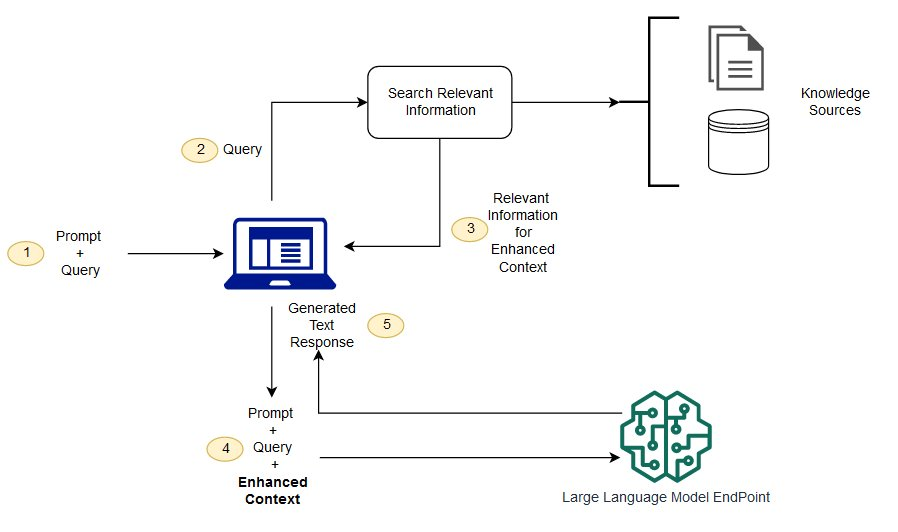

It's also a good idea to set up a pipeline to update the index. This can include a cron job to periodically update the index with new data, or a webhook to update the index when new data is available. It may also be an option for users to upload new data directly.


### References:
https://github.com/facebookresearch/faiss

https://platform.openai.com/docs/guides/embeddings/

https://aws.amazon.com/what-is/retrieval-augmented-generation/

https://medium.com/@henryhengluo/intro-of-retrieval-augmented-generation-rag-and-application-demos-c1d9239ababf

https://www.datacamp.com/blog/the-top-5-vector-databases

https://www.cs.cmu.edu/~dst/WordEmbeddingDemo/tutorial.html
